# Lab 3
## Author: Pyatkin Stanislav

Task 4: repeat the experiment with RBM pretraining and without pretraining (figure 3 from the [article](http://proceedings.mlr.press/v9/erhan10a/erhan10a.pdf)).

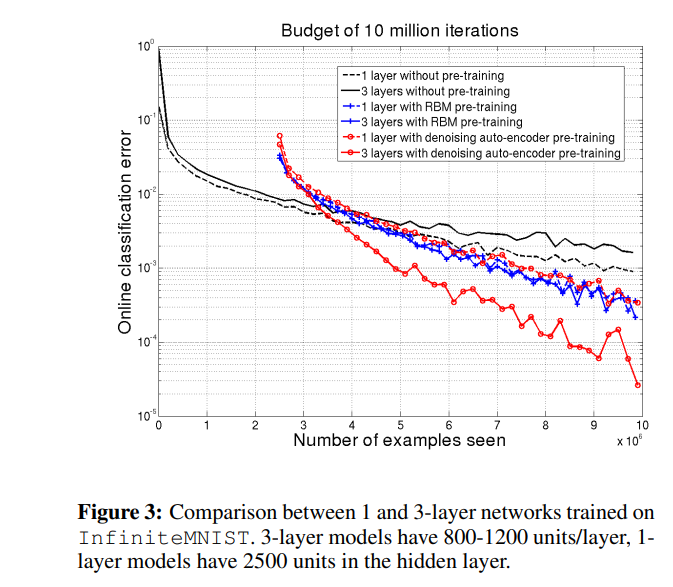

# Theory

### Restricted Boltzman Machine (RBM)

Given binary bectors $\mathbf{v}, \mathbf{h}$ - visible and hidden units. We can add regularization on parameters of linear layer via joint energy function:

$$E(\mathbf{v}, \mathbf{h}) = -\mathbf{a}^\top\mathbf{v} - \mathbf{b}^\top\mathbf{h} - \mathbf{v}^\top\mathbf{W}\mathbf{h}$$

and join probability: 
$$p(\mathbf{v}, \mathbf{h}) \propto \exp(-E(\mathbf{v}, \mathbf{h}))$$.


# Code

I have problem with my code now. My model doesn't train after pre-training (it has zero gradiend, and I don't no why)

In [16]:
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random
from jax.nn import sigmoid
from jax.scipy.special import logsumexp

from matplotlib import pyplot as plt

import time

In [17]:
# Global parameters

RBM_lr = 1e-3
DBN_lr = 1e-3

## Model

In [48]:
class RBM():
  def __init__(self, dim_v, dim_h, k):
    self.key = random.PRNGKey(9)
    key_v, key_h, key_W = random.split(self.key, num=3)
    self.v = random.normal(key_v, (dim_v,))
    self.h = random.normal(key_h, (dim_h,))
    self.W = random.normal(key_W, (dim_v, dim_h))

    self.k = k

  def visible_to_hidden(self, v):
    """
    Sample h from p(h|v)
    """

    p = sigmoid(jnp.matmul(v, self.W) + self.h)
    self.key, new_key = random.split(self.key, num=2)

    h = random.bernoulli(new_key, p).astype(jnp.float32)
    return h

  def hidden_to_visible(self, h):
    """
    Sample v from p(v|h)
    """

    p = sigmoid(jnp.matmul(h, self.W.T) + self.v)
    self.key, new_key = random.split(self.key, num=2)

    v = random.bernoulli(new_key, p).astype(jnp.float32)
    return v

  def forward(self, v):
    for _ in range(self.k):
      h = self.visible_to_hidden(v)
      v = self.hidden_to_visible(h) 
    return v, h

  def train(self, v):
    """
    Update parameters using 
    """
    h = self.visible_to_hidden(v)
    v_new, h_new = self.forward(v)

    vhT = jnp.matmul(v.transpose(), h)
    vhT_new = jnp.matmul(v_new.transpose(), h_new)

    self.W += (vhT - vhT_new) * RBM_lr / v.shape[0]
    self.h += jnp.mean(h - h_new, axis=0) * RBM_lr
    self.v += jnp.mean(v - v_new, axis=0) * RBM_lr

In [49]:
# Test

dim_v = 10
dim_h = 5

model = RBM(dim_v, dim_h, 1)

key = random.PRNGKey(9)
v = random.normal(key, (10, dim_v))
h = random.normal(key, (10, dim_h))

model.visible_to_hidden(v), model.hidden_to_visible(h)

model.train(v)

In [50]:
class DBN():
  def __init__(self, dims, k):
    self.k = k
    self.layers = []

    for (dim_in, dim_out) in zip(dims[:-1], dims[1:]):
      self.layers.append(RBM(dim_in, dim_out, k))

  def forward(self, v):
    for layer in self.layers:
      v = layer.visible_to_hidden(v)

    return v

  def pre_train(self, v):
    for layer in self.layers:
      layer.train(v)
      v = layer.visible_to_hidden(v)
      

  def return_params(self):
    params = []
    for layer in self.layers:
      params.append((layer.W, layer.h))
    return params

  def push_params(self, params):
    for layer, param in zip(self.layers, params):
      layer.W, layer.h = param
    return params

In [51]:
# Test

dims = [28*28, 500, 500, 10]
model = DBN(dims, k=5)

key = random.PRNGKey(9)
v = random.normal(key, (5, 28*28))

model.forward(v)
model.pre_train(v)

## Training

### Data

In [52]:
def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w.T, activations) + b
    activations = sigmoid(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w.T, activations) + final_b
  return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

In [53]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - DBN_lr * dw, b - DBN_lr * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [54]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [55]:
# Define our dataset, using torch datasets
batch_size = 64

mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

In [56]:
# Get the full train dataset (for checking accuracy while training)
n_targets = 10

train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Pre-Training

In [58]:
dims = [28*28, 500, 500, 500, 10]
model = DBN(dims, k=5)
num_epochs = 1

def pre_train_model(model, num_epochs=1):
  for epoch in range(num_epochs):
    for x, y in training_generator:
      model.pre_train(x)


### Training loop

In [59]:
dims = [28*28, 500, 500, 500, 10]
model = DBN(dims, k=5)
num_epochs = 10

def train(params, num_epochs):
  losses = []
  for epoch in range(num_epochs):
    start_time = time.time()

    for x, y in training_generator:
      y = one_hot(y, n_targets)
      params = update(params, x, y)

    epoch_time = time.time() - start_time

    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

    losses.append(loss(params, test_images, test_labels).mean())

  return losses

## Experiment

In [29]:
dims = [28*28, 500, 500, 500, 10]
model3 = DBN(dims, k=5)
model3_pretrain = DBN(dims, k=5)

# dims = [28*28, 500, 10]
# model1 = DBN(dims, k=5)
# model1_pretrain = DBN(dims, k=5)

In [ ]:
num_epochs = 10
num_pretrain = 1

pre_train_model(model3_pretrain, num_pretrain)

params0 = model3_pretrain.return_params().copy()
losses3_pretrain = train(params0, num_epochs - num_pretrain)

params = model3.return_params()
losses3 = train(params, num_epochs)

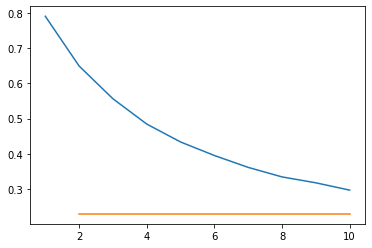

In [31]:
plt.plot(range(1, num_epochs+1), losses3)
plt.plot(range(num_pretrain+1, num_epochs+1), losses3_pretrain)